In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import random
import struct
import subprocess
import sys
from matplotlib.patches import Rectangle

In [2]:
base_dir = os.getcwd()
exec_dir = '..'

In [3]:
# Returns all records whose location is in the given range.
def range_query(df, lx, ly, ux, uy):
    return (df[(df.ACCLOC_X >= lx) & (df.ACCLOC_X <= ux) & 
              (df.ACCLOC_Y >= ly) & (df.ACCLOC_Y <= uy)])

# Returns the bounding rectangle of a Pandas dataframe.
def bounding_rect(df):
    return (np.min(df['ACCLOC_X']), np.min(df['ACCLOC_Y']), 
            np.max(df['ACCLOC_X']), np.max(df['ACCLOC_Y']))

# Generates a random rectangle inside the given interval.
def random_rect(lx, ly, ux, uy):
    # Generate a random lower-left vertex.
    px = random.uniform(lx, ux)
    py = random.uniform(ly, uy)
    width = random.uniform(0, ux-px)
    height = random.uniform(0, uy-py)
    return (px, py, px+width, py+height)

def to_string(rect):
    return '({}, {}, {}, {})'.format(rect[0],rect[1],rect[2],rect[3])

In [4]:
df = pd.read_csv('data/crash_data.csv')
df.head()

,REPORT_ID,Year,Month,Day,Time,ACCLOC_X,ACCLOC_Y
0,2012-1-27/05/2021,2012,January,Sunday,04:30 pm,1330659.71,1671795.87
1,2012-2-27/05/2021,2012,January,Sunday,09:10 am,1329400.16,1668462.66
2,2012-3-27/05/2021,2012,January,Wednesday,11:30 am,1313748.22,1624241.28
3,2012-4-27/05/2021,2012,January,Wednesday,10:20 am,1325326.77,1672425.55
4,2012-5-27/05/2021,2012,January,Wednesday,03:30 pm,1326056.45,1673028.42


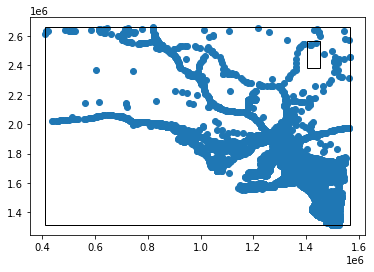

In [5]:
r = bounding_rect(df)
q = random_rect(r[0],r[1],r[2],r[3])
plt.scatter(df['ACCLOC_X'], df['ACCLOC_Y'])
plt.gca().add_patch(Rectangle((r[0], r[1]), r[2]-r[0], r[3]-r[1], fill=None, alpha=1))
plt.gca().add_patch(Rectangle((q[0], q[1]), q[2]-q[0], q[3]-q[1], fill=None, alpha=1))

# Query generation

First experiment: generate random queries.

# Random queries

We fix $m = 50000$, $c=20$ and perform 1000 queries which are randomly selected among the ones we have generated.
We measure the average query and verification times.

# Fraction of records (10%-90%)

Selected query IDs:

|  F  |  ID  |
|:---:|:----:|
| 10% | 7323 |
| 20% | 26   |
| 30% | 4515 |
| 40% | 2823 |
| 50% | 7182 |
| 60% | 3734 |
| 70% | 1338 |
| 80% | 1131 |
| 90% | 8966 |

In [6]:
def print_fraction(df, fmin, fmax):
    return (df[(df.fraction > fmin) & (df.fraction <= fmax)]).sort_values('fraction')

In [7]:
m=50000
c=20
query_df = pd.read_csv('./test_query_verification/queries.csv')
query_ids = [7323, 26, 4515, 2823, 7182, 3734, 1338, 1131, 8966]
n_trials=20

In [8]:
input_file = '{}/test_query_verification/crash_data_{}.csv'.format(base_dir, m)
output_file = '{}/test_query_verification/test_fraction.csv'.format(base_dir)
test_df = pd.read_csv(input_file)

f = open(output_file, 'w')
f.write('fraction,returned,matching,avg_query,avg_verif\n')

os.chdir(exec_dir)

for qid in query_ids:
    query = query_df.loc[qid]
    q = (query.lx, query.ly, query.ux, query.uy)
    # Run the C++ implementation.
    print('Testing q = {}...'.format(to_string(q)))
    avg_query, avg_verif, returned_rec, matching_rec = 0, 0, 0, 0
    for i in range(0, n_trials):
        params = ['./TestQuery', input_file, str(c), str(q[0]), str(q[1]), str(q[2]), str(q[3])]
        p = subprocess.run(params, capture_output=True, check=True)
        lines = p.stdout.decode('utf-8').splitlines()
        returned_rec += int((lines[2].split(':'))[1])
        matching_rec += int((lines[3].split(':'))[1])
        avg_query += int((lines[4].split(':'))[1])
        avg_verif += int((lines[5].split(':'))[1])
    returned_rec /= n_trials 
    matching_rec /= n_trials
    avg_query /= n_trials
    avg_verif /= n_trials
    f.write('{},{},{},{},{}\n'.format(query.fraction,returned_rec,matching_rec,avg_query,avg_verif))

f.close()

os.chdir(base_dir)
print('Done!')

Testing q = (997923.198619161, 1558406.4419705148, 1319835.4583058036, 2629320.42603949)...
Testing q = (1157641.0138630343, 1683783.3693743732, 1461543.232077348, 2055540.3656423616)...
Testing q = (1239611.6155656772, 1469332.0660300502, 1325904.56827415, 1862367.547333857)...
Testing q = (1044485.882382357, 1674909.8671160382, 1454703.58104226, 2108267.1311829914)...
Testing q = (1294312.379426788, 1671411.025779427, 1470627.338848919, 2518146.158722629)...
Testing q = (1300543.9466481828, 1668891.3886098117, 1512512.705079927, 1954040.253304719)...
Testing q = (709315.0886249999, 1663851.4289746964, 1435565.5497201788, 1723813.4023714047)...
Testing q = (725598.1453333314, 1661606.186857487, 1564111.3644731976, 2633604.596985729)...
Testing q = (766763.0224548833, 1646890.2957389615, 1427003.449221035, 2375236.7044423344)...
Done!


In [26]:
df=pd.read_csv('./test_query_verification/test_fraction.csv')
# Convert returned and matching columns to integer type.
df = df.astype({'returned': int, 'matching': int})
# Divide by 1000 to convert microseconds to milliseconds.
df['avg_query'] /= 1000
df['avg_verif'] /= 1000
# Round the execution times to 3 decimal places.
df = df.round({'avg_query': 3, 'avg_verif': 3})
print(df.to_latex(index=False))

\begin{tabular}{rrrrr}
\toprule
 fraction &  returned &  matching &  avg\_query &  avg\_verif \\
\midrule
  0.10296 &      5600 &      5148 &      0.625 &      6.790 \\
  0.20120 &     47600 &     10060 &      5.340 &     34.176 \\
  0.30520 &     16400 &     15260 &      1.851 &     21.238 \\
  0.41442 &     48400 &     20721 &      5.725 &     43.994 \\
  0.50042 &     46000 &     25021 &      5.301 &     47.124 \\
  0.61756 &     47200 &     30878 &      5.684 &     52.796 \\
  0.70100 &     48400 &     35050 &      5.572 &     58.478 \\
  0.80042 &     50000 &     40021 &      5.524 &     62.722 \\
  0.90000 &     48400 &     45000 &      5.326 &     66.519 \\
\bottomrule
\end{tabular}



# Low fractions (1%-9%)

In [10]:
m=50000
c=20
n_trials=20

query_df = pd.read_csv('./test_query_verification/queries.csv')
query_ids = [8846, 557, 6001, 1746, 3456, 7561, 3818, 5366, 4192]
input_file = '{}/test_query_verification/crash_data_{}.csv'.format(base_dir, m)
output_file = '{}/test_query_verification/test_fraction_low.csv'.format(base_dir)
test_df = pd.read_csv(input_file)

f = open(output_file, 'w')
f.write('fraction,returned,matching,avg_query,avg_verif\n')

os.chdir(exec_dir)

for qid in query_ids:
    query = query_df.loc[qid]
    q = (query.lx, query.ly, query.ux, query.uy)
    # Run the C++ implementation.
    print('Testing q = {}...'.format(to_string(q)))
    avg_query, avg_verif, returned_rec, matching_rec = 0, 0, 0, 0
    for i in range(0, n_trials):
        params = ['./TestQuery', input_file, str(c), str(q[0]), str(q[1]), str(q[2]), str(q[3])]
        p = subprocess.run(params, capture_output=True, check=True)
        lines = p.stdout.decode('utf-8').splitlines()
        returned_rec += int((lines[2].split(':'))[1])
        matching_rec += int((lines[3].split(':'))[1])
        avg_query += int((lines[4].split(':'))[1])
        avg_verif += int((lines[5].split(':'))[1])
    returned_rec /= n_trials 
    matching_rec /= n_trials
    avg_query /= n_trials
    avg_verif /= n_trials
    f.write('{},{},{},{},{}\n'.format(query.fraction,returned_rec,matching_rec,avg_query,avg_verif))

f.close()

os.chdir(base_dir)
print('Done!')

Testing q = (942146.4828215725, 1601094.6764700513, 1186940.8920336757, 2002733.5569788069)...
Testing q = (1195006.9123851154, 1822915.6191936345, 1334405.8580820167, 2327513.6636538645)...
Testing q = (862069.3583306521, 1512952.002674613, 1258714.281072412, 2273237.600525875)...
Testing q = (924247.7129558946, 1760586.635249185, 1474485.3012335233, 2304914.5786552755)...
Testing q = (736030.4439881082, 1315892.1643492484, 1306169.1747889316, 2413979.3748069825)...
Testing q = (1260005.0356259854, 1699595.5640831431, 1502337.8553615368, 1922775.105442376)...
Testing q = (1344953.1781479376, 1608583.6269631651, 1495202.0046324665, 2632597.7046906888)...
Testing q = (667993.7867674043, 1696273.7010104558, 1462892.0594907994, 1814201.717823445)...
Testing q = (971084.5911677694, 1698628.0895208037, 1469963.2430290284, 2498029.334852431)...
Done!


In [27]:
df=pd.read_csv('./test_query_verification/test_fraction_low.csv')
# Convert returned and matching columns to integer type.
df = df.astype({'returned': int, 'matching': int})
# Divide by 1000 to convert microseconds to milliseconds.
df['avg_query'] /= 1000
df['avg_verif'] /= 1000
# Round the execution times to 3 decimal places.
df = df.round({'avg_query': 3, 'avg_verif': 3})
print(df.to_latex(index=False))

\begin{tabular}{rrrrr}
\toprule
 fraction &  returned &  matching &  avg\_query &  avg\_verif \\
\midrule
  0.01002 &      1200 &       501 &      0.145 &      1.089 \\
  0.02014 &     17200 &      1007 &      1.937 &     10.078 \\
  0.03008 &      2000 &      1504 &      0.247 &      2.272 \\
  0.04006 &     37200 &      2003 &      4.423 &     21.551 \\
  0.05022 &      2800 &      2511 &      0.310 &      3.145 \\
  0.06002 &     44800 &      3001 &      5.235 &     26.533 \\
  0.07040 &      4400 &      3520 &      0.471 &      4.682 \\
  0.08042 &     46800 &      4021 &      5.206 &     28.381 \\
  0.09028 &     46000 &      4514 &      5.528 &     28.602 \\
\bottomrule
\end{tabular}



# Capacity

Our second analysis was aimed at studying 
how the page capacity impacts on the execution times
of query and verification algorithms. 
For this reason, we chose a data set with 
$m = 2 \times 10^4$ records, a query $Q$
with a fraction $f_Q = 20\%$ and then constructed
several MR-trees with different page capacities.
For each tree, we executed the query and verification
algorithms 20 times and computed an average of
their running times. 

In [11]:
m=20000
capacities=[5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 250, 500, 750, 1000]
n_trials=20
input_file = '{}/test_query_verification/crash_data_{}.csv'.format(base_dir, m)
output_file = '{}/test_query_verification/test_capacity.csv'.format(base_dir)
test_df = pd.read_csv(input_file)
query_df = pd.read_csv('./test_query_verification/queries_capacity.csv')
query_id = 4859
q = query_df.loc[4859]

f = open(output_file, 'w')
f.write('capacity,returned,matching,avg_query,avg_verif\n')

os.chdir(exec_dir)

for c in capacities:
    # Run the C++ implementation.
    print('Testing capacity = {}...'.format(c))
    avg_query, avg_verif, returned_rec, matching_rec = 0, 0, 0, 0
    for i in range(0, n_trials):
        params = ['./TestQuery', input_file, str(c), str(q.lx), str(q.ly), str(q.ux), str(q.uy)]
        p = subprocess.run(params, capture_output=True, check=True)
        lines = p.stdout.decode('utf-8').splitlines()
        returned_rec += int((lines[2].split(':'))[1])
        matching_rec += int((lines[3].split(':'))[1])
        avg_query += int((lines[4].split(':'))[1])
        avg_verif += int((lines[5].split(':'))[1])
    returned_rec /= n_trials 
    matching_rec /= n_trials
    avg_query /= n_trials
    avg_verif /= n_trials
    f.write('{},{},{},{},{}\n'.format(c,returned_rec,matching_rec,avg_query,avg_verif))

f.close()

os.chdir(base_dir)
print('Done!')

Testing capacity = 5...
Testing capacity = 10...
Testing capacity = 20...
Testing capacity = 30...
Testing capacity = 40...
Testing capacity = 50...
Testing capacity = 60...
Testing capacity = 70...
Testing capacity = 80...
Testing capacity = 90...
Testing capacity = 100...
Testing capacity = 250...
Testing capacity = 500...
Testing capacity = 750...
Testing capacity = 1000...
Done!


In [14]:
df=pd.read_csv('./test_query_verification/test_capacity.csv')
# Convert returned and matching columns to integer type.
df = df.astype({'returned': int, 'matching': int})
# Divide by 1000 to convert microseconds to milliseconds.
df['avg_query'] /= 1000
df['avg_verif'] /= 1000
# Round the execution times to 3 decimal places.
df = df.round({'avg_query': 3, 'avg_verif': 3})
print(df.to_latex(index=False))

\begin{tabular}{rrrrr}
\toprule
 capacity &  returned &  matching &  avg\_query &  avg\_verif \\
\midrule
        5 &      4175 &      4120 &      0.755 &     10.075 \\
       10 &      4300 &      4120 &      0.469 &      6.412 \\
       20 &      4800 &      4120 &      0.404 &      5.411 \\
       30 &      5400 &      4120 &      0.386 &      4.625 \\
       40 &      4800 &      4120 &      0.296 &      4.240 \\
       50 &      7500 &      4120 &      0.482 &      5.124 \\
       60 &      5600 &      4120 &      0.368 &      4.180 \\
       70 &      4900 &      4120 &      0.305 &      3.732 \\
       80 &      6400 &      4120 &      0.427 &      4.382 \\
       90 &     11900 &      4120 &      0.732 &      6.818 \\
      100 &     10000 &      4120 &      0.731 &      5.728 \\
      250 &     20000 &      4120 &      1.314 &      9.026 \\
      500 &     20000 &      4120 &      1.790 &      9.496 \\
      750 &     20000 &      4120 &      1.566 &      9.597 \\
     1000 & 

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


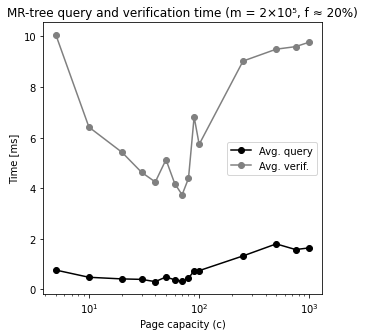

In [22]:
plt.figure(figsize=(5, 5))
plt.title("MR-tree query and verification time (m = 2×10⁵, f ≈ 20%)")
plt.xticks(df['capacity'])
plt.xscale('log')
plt.plot(df['capacity'], df['avg_query'], marker='o', color='black', label='Avg. query')
plt.plot(df['capacity'], df['avg_verif'], marker='o', color='grey', label='Avg. verif.')
#plt.axvline(75, 0, 1, color='gray', linestyle='--')
plt.ylabel("Time [ms]")
plt.xlabel("Page capacity (c)")
plt.legend()
plt.savefig("test_query_verification/test-capacity.eps", format='eps', bbox_inches='tight')